In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm   # implements a "status bar" for iterations


def divergence(f):
    """
    Computes the divergence of the vector field f.
    """
    num_dims = len(f.shape)-1
    return np.ufunc.reduce(np.add, [np.gradient(f[...,i], axis=i) for i in range(num_dims)])


def step_dual_chan_vese(u, z, c1, c2, lambd, image_arr, step_u, step_z):
    """
    A "primal-dual" algorithm for minimizing a dual formulation of the convexified Chan-Vese functional.
    Consult the last part of https://www.math.u-bordeaux.fr/~npapadak/TP/TP2.pdf for more information
    """
    def clip_z(z):
        """ 
        Helper functions to truncate z to have at most unit pointwise norm.
        If z has norm ≤ 1, we do nothing, otherwise we replace it by z/norm(z)
        """
        def criterion(v):
            norm = np.linalg.norm(v)
            if norm > 1:
                return v/norm
            else:
                return v

        return np.apply_along_axis(criterion, -1, z)
        #return z / ((1 + np.maximum(0, np.apply_along_axis(np.linalg.norm, -1, z) - 1))[...,np.newaxis])

    z_update = clip_z(z + step_z * np.stack(np.gradient(u), axis=-1))
    tmp = lambd * ((image_arr - c1)**2 - (image_arr-c2)**2)
    u_update = np.clip(u + step_u*(divergence(z_update) - tmp), 0 , 1)

    return (u_update, z_update)


def energy(u,c1,c2, lambd, image_arr):
    """
    Calculates the "convexified Chan-Vese" functional.
    """
    TV_energy = np.sum(np.apply_along_axis(np.linalg.norm, -1, np.stack(np.gradient(u), axis=-1)))
    data_fitting = np.sum((image_arr - c1)**2 * u + (image_arr - c2)**2 * (1-u))
    return TV_energy + lambd * data_fitting

In [32]:
bitmap_array = np.array(Image.open("images/dirty.bmp"), dtype=float)

u = np.zeros(bitmap_array.shape, dtype=float)
z = np.zeros(bitmap_array.shape+(len(u.shape),), dtype=float)
c1 = 50
c2 = 200
lambd = 1e-5  # has to be so small because of the scale of pixel intensity

iterations = 250
energy_curve = np.zeros(iterations)

for i in tqdm(range(iterations)):
    (u,z) = step_dual_chan_vese(u,z, c1, c2, lambd, bitmap_array, 0.2,0.3)
    energy_curve[i] = energy(u, c1, c2, lambd, bitmap_array)

100%|██████████| 250/250 [00:53<00:00,  4.70it/s]


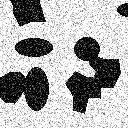

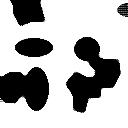

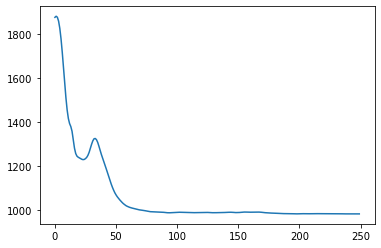

In [33]:
x = np.array(255 * (1-u), dtype=np.uint8)
plt.plot(energy_curve)
display(Image.open("images/dirty.bmp"))
display(Image.fromarray(x))